In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from tqdm import tqdm_notebook
progress = tqdm_notebook()

RAW_DATA_DIR = '../data/raw/'
CLEAN_DATA_DIR = '../data/clean/'

A Jupyter Widget

# Import and process data


### Demographics

In [2]:
demographics_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Demographics_20170116.csv', 
                               index_col=0, parse_dates=['DOB'], infer_datetime_format=True)
demographics_raw.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEX,RACE,ETHNICITY,DOB,DOD,ZIP_CODE
MRN,,,,,,
28997286,2,7,UN,1958-01-09,NaN,422100000
22710289,2,2,NH,1969-09-11,NaN,370640000
15333065,1,1,NH,1996-12-28,NaN,372060000
11732831,1,2,NH,1991-01-31,NaN,370400000
26724542,2,1,NH,1958-08-19,NaN,421340000


In [3]:
demographics_raw.shape

(529428, 6)

In [4]:
demographics_raw.index.is_unique

True

Recode categorical variables to something useful

In [5]:
demographics_raw['male'] = (demographics_raw.SEX==1).astype(int)

In [6]:
demographics_raw['race'] = demographics_raw.RACE.replace(dict(zip(range(1, 8), ['white', 'black', 'native', 'asian', 
                                                     'hispanic', 'other', 'unknown'])))

In [7]:
demographics_raw.race.value_counts()

white       419554
black        52455
unknown      32724
hispanic     13540
asian         9708
other          729
native         718
Name: race, dtype: int64

In [8]:
demographics_raw.ETHNICITY.value_counts()

NH    450556
UN     65332
HL     13540
Name: ETHNICITY, dtype: int64

In [9]:
demographics_raw['hispanic'] = (demographics_raw.ETHNICITY=='HL')
demographics_raw.loc[demographics_raw.ETHNICITY=='UN', 'hispanic'] = np.nan

There are no non-null death dates.

In [10]:
demographics_raw.isnull().mean()

SEX          0.000000
RACE         0.000000
ETHNICITY    0.000000
DOB          0.000000
DOD          1.000000
ZIP_CODE     0.001067
male         0.000000
race         0.000000
hispanic     0.123401
dtype: float64

Drop date of death and ethnicity

In [11]:
demographics = demographics_raw.drop(['DOD', 'ETHNICITY'], axis=1)
del demographics_raw

In [12]:
demographics.shape

(529428, 7)

### Patient flags

In [13]:
flags = pd.read_csv(RAW_DATA_DIR + '400k_flag_v2.csv', index_col=0)
flags.head()

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,htn_flag,chf_flag,esrd_flag,copd_flag,dprn_flag,hlpd_flag,malig_flag,smoke_flag,ckd_flag,cad_flag,lbp_flag,thyroid_flag,osa_flag,asthma_flag,t1dm_flag,bariatric_surgery_cpt_flag,amputation_cpt_flag
patient_id,,,,,,,,,,,,,,,,,
10000073,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000420,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10000933,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10001162,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
flagged_demographics = demographics.join(flags)
flagged_demographics.shape
del flags

### Height measurements

Perhaps choose modal or median for each patient.

In [15]:
height_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Height_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
height_raw.head()

,MRN,HEIGHT_DATE,HEIGHT
0,1887330,2016-02-22,157.48
1,1887330,2012-01-17,162.56
2,1887330,2013-02-15,162.56
3,1887330,2013-05-17,162.56
4,1887330,2013-08-07,162.56


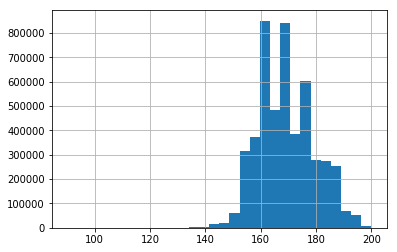

In [16]:
plt.figure()
height_raw.HEIGHT[(height_raw.HEIGHT<200) & (height_raw.HEIGHT>0) ].hist(bins=30)

### Weight data

In [17]:
weight_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_weight_20170213.csv', 
                         parse_dates=[1], infer_datetime_format=True)
weight_raw.head()

,MRN,WEIGHT_DATE,WEIGHT,PREGNANCY_INDICATOR
0,7695679,2006-01-27,62.60,1
1,7695679,2006-02-08,62.60,1
2,7695679,2006-02-08,62.60,1
3,7695679,2006-03-08,63.96,1
4,7695679,2006-10-02,65.77,1


Only take individuals with 5 or more observations

In [18]:
weights_nonpreg = weight_raw[weight_raw.PREGNANCY_INDICATOR==0].drop('PREGNANCY_INDICATOR', axis=1)

In [19]:
weight_counts = weights_nonpreg.groupby('MRN')['WEIGHT_DATE'].count()

In [20]:
MIN_MEASUREMENTS = 5
min_weights = weight_counts[weight_counts>=MIN_MEASUREMENTS].index.values

In [21]:
filtered_weights = weights_nonpreg[weights_nonpreg.MRN.isin(min_weights)]

In [22]:
assert not filtered_weights.isnull().sum().any()

Apply Greevy flagging algorihtm

In [23]:
from scipy.stats import chi2

def calc_concordance(patient, m=-0.032, sd=3.52):
    p = []
    nobs = 11
    for i,x in patient.iterrows():

        # Calculate deltas
        df = (pd.DataFrame({'uid':i, 
                           'delta_W':patient.WEIGHT - x.WEIGHT, 
                           'delta_T':(patient.WEIGHT_DATE - x.WEIGHT_DATE).dt.days.abs()})
             .sort_values('delta_T')[1:nobs] 
             .assign(measurement=np.arange(1, nobs), weight_date=x.WEIGHT_DATE)) 

        # Calculate statistic
        prob = 1 - chi2.cdf(((df.delta_W - m)/sd) ** 2, 1) 

        # Convert to concordance probability
        p.append({'uid':i, 'p':prob.mean()})


    return pd.DataFrame(p).set_index('uid')


In [24]:
recalculate_weights = False

if recalculate_weights:
    progress.pandas(desc='concordance probability calculation')
    concordance = (filtered_weights.groupby('MRN')
                   .progress_apply(calc_concordance))
    concordance.to_csv(CLEAN_DATA_DIR+'concordance.csv')
    # Add a relative date (to first measurement) of each measurement
    concordance.index = concordance.index.droplevel('MRN')
else:
    concordance = pd.read_csv(CLEAN_DATA_DIR+'concordance.csv', index_col=0)

/Users/fonnescj/anaconda3/envs/dev/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [25]:
(concordance.p<0.01).mean()

0.0047287468770074569

Proportion excluded as a function of concordance threshold.

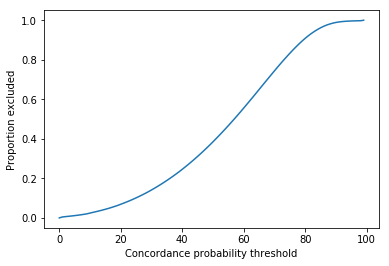

In [26]:
plt.figure()
plt.plot([(concordance.p<p).mean() for p in np.linspace(0, 1, 100)])
plt.xlabel('Concordance probability threshold')
plt.ylabel('Proportion excluded');

Merge concordance probabilities

In [27]:
weights = filtered_weights.join(concordance)

In [28]:
weights['Weight_filtered'] = weights.WEIGHT.copy()
weights.loc[weights.p<0.05, 'Weight_filtered'] = np.nan

In [29]:
len(set(weight_raw.MRN))

526996

Add age to each measurement

In [30]:
weights = weights.merge(demographics[['DOB']], left_on='MRN', right_index=True)
weights['AGE'] = (weights.WEIGHT_DATE - weights.DOB).astype('<m8[Y]')

Calculate BMI

In [39]:
bmi = weights.merge(height_raw, left_on=['MRN', 'WEIGHT_DATE'], 
              right_on=['MRN', 'HEIGHT_DATE'])
bmi['BMI'] = bmi.Weight_filtered / (bmi.HEIGHT / 100)**2

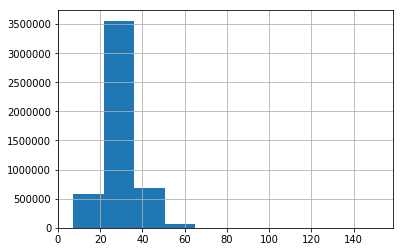

In [40]:
bmi.BMI.hist()

In [41]:
bmi.shape

(4890300, 11)

In [42]:
bmi.head()

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI
0,1829209,2012-06-25,67.77,NaN,NaN,67.77,1928-03-01,84.0,2012-06-25,149.86,30.176303
1,1829209,2013-02-28,68.04,NaN,NaN,68.04,1928-03-01,84.0,2013-02-28,152.40,29.295059
2,2618890,2010-08-05,82.55,NaN,NaN,82.55,1942-12-16,67.0,2010-08-05,170.18,28.503621
3,2618890,2015-08-11,83.01,NaN,NaN,83.01,1942-12-16,72.0,2015-08-11,172.72,27.825640
4,2618890,2016-09-06,83.91,NaN,NaN,83.91,1942-12-16,73.0,2016-09-06,172.72,28.127327


### Survey subset

Import survey dates for each patient

In [34]:
survey_dates = (pd.read_csv(RAW_DATA_DIR+"patient_id_survey_date_with_mrn.csv", parse_dates=['survey_date'])
                        .rename(columns={'survey_mrn':'MRN'})
                        .drop('patient_id', axis=1))

In [35]:
bmi = bmi.merge(survey_dates, on='MRN')

In [36]:
bmi.shape

(130631, 12)

In [37]:
bmi.head()

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI,survey_date
0,2618890,2010-08-05,82.55,NaN,NaN,82.55,1942-12-16,67.0,2010-08-05,170.18,28.503621,2015-03-11
1,2618890,2015-08-11,83.01,NaN,NaN,83.01,1942-12-16,72.0,2015-08-11,172.72,27.825640,2015-03-11
2,2618890,2016-09-06,83.91,NaN,NaN,83.91,1942-12-16,73.0,2016-09-06,172.72,28.127327,2015-03-11
3,2618890,2012-06-08,85.28,NaN,NaN,85.28,1942-12-16,69.0,2012-06-08,172.72,28.586562,2015-03-11
4,2618890,2014-04-04,85.28,NaN,NaN,85.28,1942-12-16,71.0,2014-04-04,172.72,28.586562,2015-03-11


In [38]:
data_2_years = bmi.groupby('MRN').apply(lambda x: sum((x.survey_date - x.WEIGHT_DATE).dt.days < 730))

In [39]:
sum(data_2_years > 5)

3665

## BMI subset

Generate subset of patients whose initial BMI is between 27 and 30

In [40]:
def initial_bmi(patient):
    return patient.BMI[patient.WEIGHT_DATE==patient.WEIGHT_DATE.min()].mean()

progress.pandas(desc='relative date calculation')

initial_bmi = bmi.groupby('MRN').progress_apply(initial_bmi)

A Jupyter Widget

In [41]:
init_range = initial_bmi[(initial_bmi>=27) & (initial_bmi<=30)].index.values

In [42]:
bmi_init_range = bmi[bmi.MRN.isin(init_range)].copy()
bmi_init_range.MRN.unique().shape

(792,)

In [43]:
# Rescue some memory
del weights
del height_raw

Pivot table of weight by date and patient

In [44]:
bmi_init_range.head()

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI,survey_date
0,2618890,2010-08-05,82.55,NaN,NaN,82.55,1942-12-16,67.0,2010-08-05,170.18,28.503621,2015-03-11
1,2618890,2015-08-11,83.01,NaN,NaN,83.01,1942-12-16,72.0,2015-08-11,172.72,27.825640,2015-03-11
2,2618890,2016-09-06,83.91,NaN,NaN,83.91,1942-12-16,73.0,2016-09-06,172.72,28.127327,2015-03-11
3,2618890,2012-06-08,85.28,NaN,NaN,85.28,1942-12-16,69.0,2012-06-08,172.72,28.586562,2015-03-11
4,2618890,2014-04-04,85.28,NaN,NaN,85.28,1942-12-16,71.0,2014-04-04,172.72,28.586562,2015-03-11


In [45]:
def calc_rel_date(patient):
    return patient.WEIGHT_DATE - patient.WEIGHT_DATE.min()


progress.pandas(desc='relative date calculation')

relative_date = bmi_init_range.groupby('MRN').progress_apply(calc_rel_date)

A Jupyter Widget

Add relative date (`WEIGHT_DAY`) to data frame

In [46]:
bmi_init_range['WEIGHT_DAY']  = (relative_date.reset_index(level=0)
                                             .rename(columns={'WEIGHT_DATE':'WEIGHT_DAY'})
                                             .WEIGHT_DAY)

In [47]:
bmi_init_range.head()

,MRN,WEIGHT_DATE,WEIGHT,uid,p,Weight_filtered,DOB,AGE,HEIGHT_DATE,HEIGHT,BMI,survey_date,WEIGHT_DAY
0,2618890,2010-08-05,82.55,NaN,NaN,82.55,1942-12-16,67.0,2010-08-05,170.18,28.503621,2015-03-11,0 days
1,2618890,2015-08-11,83.01,NaN,NaN,83.01,1942-12-16,72.0,2015-08-11,172.72,27.825640,2015-03-11,1832 days
2,2618890,2016-09-06,83.91,NaN,NaN,83.91,1942-12-16,73.0,2016-09-06,172.72,28.127327,2015-03-11,2224 days
3,2618890,2012-06-08,85.28,NaN,NaN,85.28,1942-12-16,69.0,2012-06-08,172.72,28.586562,2015-03-11,673 days
4,2618890,2014-04-04,85.28,NaN,NaN,85.28,1942-12-16,71.0,2014-04-04,172.72,28.586562,2015-03-11,1338 days


In [48]:
bmi_by_patient = pd.pivot_table(bmi_init_range, 
                        index='WEIGHT_DATE', columns='MRN', values='BMI')

Resample to monthly

In [49]:
monthly_bmi = bmi_by_patient.resample('M').median()

In [50]:
monthly_bmi.tail()

MRN,1115302,2163756,2340131,2415545,2503977,2543577,2547198,2569176,2580231,2618890,...,37047917,37135761,37357266,37488566,37506912,37524758,37682457,37829173,37834199,38002663
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
2016-08-31,25.989655,NaN,32.024857,30.052479,32.633330,NaN,NaN,29.055854,NaN,NaN,...,27.184053,NaN,NaN,30.597470,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-30,25.989655,NaN,32.062220,29.850866,NaN,27.529033,NaN,NaN,NaN,28.127327,...,NaN,NaN,NaN,NaN,NaN,NaN,31.355442,NaN,NaN,NaN
2016-10-31,25.546890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.184053,NaN,NaN,NaN,NaN,33.406872,NaN,29.290327,NaN,NaN
2016-11-30,26.395794,NaN,32.578176,NaN,NaN,NaN,NaN,28.935179,NaN,NaN,...,NaN,NaN,NaN,31.195702,NaN,NaN,31.355442,NaN,32.754996,NaN
2016-12-31,26.892088,NaN,NaN,NaN,32.149399,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.864198,NaN,NaN,31.355442,NaN,NaN,NaN


In [106]:
monthly_bmi

MRN,1115302,2163756,2340131,2415545,2503977,2543577,2547198,2569176,2580231,2618890,...,37047917,37135761,37357266,37488566,37506912,37524758,37682457,37829173,37834199,38002663
WEIGHT_DATE,,,,,,,,,,,,,,,,,,,,,
2002-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
def shift_null(x):
    first_notnull = x[x.notnull()].index.min()
    return x.shift(-first_notnull)

In [74]:
def shift_null_array(x):
    first_non_null = np.nonzero(~np.isnan(x))[0][0]
    shifted = x[first_non_null:]
    x_shifted = np.full_like(x, np.nan) 
    x_shifted[:len(shifted)] = shifted
    return x_shifted

In [78]:
bmi_shifted = np.array([shift_null_array(x) for x in monthly_bmi.values.T])

In [89]:
first_2yrs = bmi_shifted[:, :24]

In [154]:
subset_2yrs = pd.DataFrame(first_2yrs, index=monthly_bmi.columns)
subset_2yrs.shape

(792, 24)

In [156]:
subset_2yrs.to_csv(CLEAN_DATA_DIR+'subset_2yrs.csv')

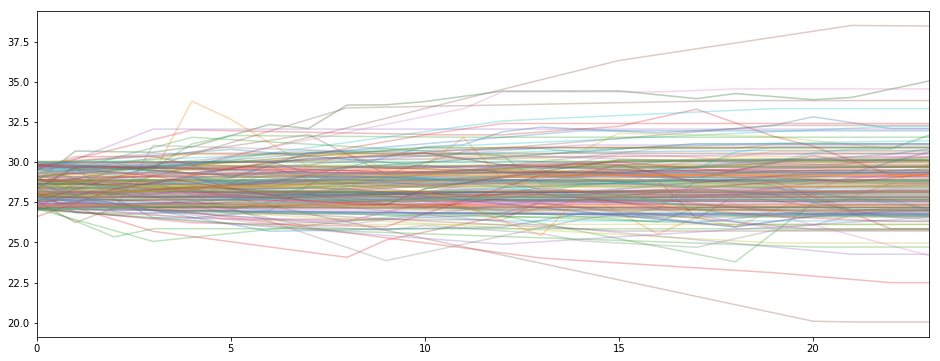

In [150]:
(pd.DataFrame(first_2yrs[np.random.choice(np.arange(len(first_2yrs)), 200)]).T.interpolate()
                    .plot(legend=False, alpha=0.3, figsize=(16,6)))

In [ ]:
subset_2yrs.to_csv(CLEAN_DATA_DIR+'subset_2yrs.csv')

Take first 2 years

In [55]:
first_2yrs = weekly_bmi.iloc[:104]
subset_2yrs = first_2yrs.loc[:, first_2yrs.count() >=5]

In [56]:
subset_2yrs.shape

(104, 168)

Here is a random 50 trajectories

In [90]:
axes = (subset_2yrs[np.random.choice(subset_2yrs.columns, 50)]
                    .interpolate()
                    .plot(legend=False, alpha=0.3, figsize=(16,6)))
axes.set_ylabel('BMI');

NameError: name 'subset_2yrs' is not defined

In [58]:
subset_2yrs.to_csv(CLEAN_DATA_DIR+'subset_2yrs.csv')

### Lab values

In [42]:
lab_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_Lab_20170213.csv', 
                      usecols = ['MRN','LAB_DATE','LAB_VALUE','LAB_NAME','LAB_UNIT'],
                      parse_dates=[1], infer_datetime_format=True)
lab_raw.head()

,MRN,LAB_DATE,LAB_VALUE,LAB_NAME,LAB_UNIT
0,2156149,10/09/2013,1.09,Creat,mg/dL
1,2156149,10/09/2013,1.04,Creat,mg/dL
2,2156149,10/09/2013,0.89,Creat,mg/dL
3,2156149,10/10/2013,0.89,Creat,mg/dL
4,2156149,10/10/2013,0.97,Creat,mg/dL


In [43]:
lab_raw.shape

(8496974, 5)

### ICD codes

In [44]:
icd_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_ICD_9_10_20170116.csv', 
                      parse_dates=[1], infer_datetime_format=True)
icd_raw.head()

,MRN,EVENT_DATE,ICD_CODE,CODE_TYPE
0,2360139,2003-01-07,401.1,9
1,2360139,2002-01-08,401.1,9
2,2360139,2003-01-08,401.1,9
3,2360139,2005-01-11,401.1,9
4,2360139,2004-01-13,401.9,9


In [45]:
icd_raw.shape

(8796137, 4)

In [46]:
icd_raw.CODE_TYPE.value_counts()


9     7098563
10    1697574
Name: CODE_TYPE, dtype: int64

### CPT codes

In [51]:
cpt_raw = pd.read_csv(RAW_DATA_DIR + 'pcori_heerman_cohort_CPT_20170116.csv',
                     parse_dates=[1], infer_datetime_format=True)
cpt_raw.head()

,MRN,CPT_DATE,CPT_CODE
0,31275076,2012-05-29,43775
1,31275076,2012-05-29,43775
2,31275076,2012-05-29,43775
3,31275076,2012-05-29,43775
4,31275076,2012-05-29,43775


In [52]:
cpt_raw.isnull().mean()


MRN         0.0
CPT_DATE    0.0
CPT_CODE    0.0
dtype: float64

In [53]:
demographics_raw.merge(cpt_raw, left_index=True, right_on='MRN', how='inner').shape

(65769, 12)